In [1]:
import keras
import tensorflow as tf

# Memory Pre-configuration
config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        per_process_gpu_memory_fraction=0.9,
        allow_growth = True
    )
    # device_count = {'GPU': 1}
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

#tf.compat.v1.disable_eager_execution()

순환 신경망의 성능과 일반화 능력을 향상시키기 위한 3가지 고급 기술을 살펴보겠습니다.
* **순환 드랍아웃 (Recurrent Dropout)**: 순환 층에서 과대적합을 방지하기 위해 드롭아웃을 사용
* **스태킹 순환 층 (Stacking Recurrent Layer)**: 네트워크의 표현 능력 (representation power)을 증가시킴
* **양방향 순환 층 (Bidirectional Recurrent Layer)**: 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킴

### 기온 예측 문제

`예나`시의 온도 예측 문제를 시연해보겠습니다.
* 이 시계열 데이터는 건물 옥상에 설치된 센서에서 취득한 온도, 기압, 습도 같은 데이터입니다
* 이 데이터를 사용하여 마지막 데이터 포인트에서 24시간 이후의 온도를 예측하겠습니다
* 데이터셋에는 수년간 걸쳐 14개의 관측치가 10분마다 기록되어있습니다.
* 원본에는 2003년부터 기록되어 있지만 이 예제에서는 2009 ~ 2016년 사이의 데이터만 사용합니다

```bash
cd ./data/
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.zip
```

##### 예나의 날씨 데이터 조사하기

In [2]:
import os

data_dir = "./data/jena_climate/"
fname = os.path.join(data_dir, "jena_climate_2009_2016.csv")

f = open(fname)
data = f.read()
f.close()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


출력된 줄 수는 42만 451입니다.

##### 데이터 파싱

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    float_data[i,:] = values

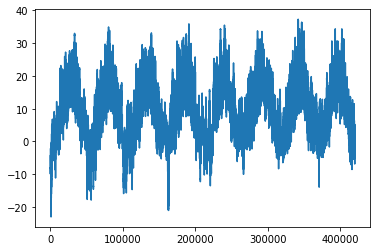

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1] ## 온도 (섭씨)
plt.plot(range(len(temp)), temp)

다음은 기간을 좁혀서 처음 10일간 온도 데이터를 나타낸 그래프입니다. 10분마다 데이터가 기록되므로 하루에 총 144개의 데이터 포인트가 있습니다

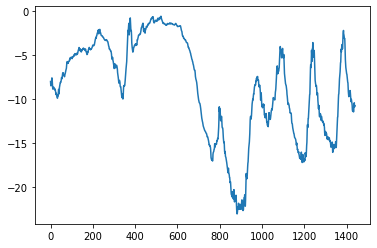

In [5]:
plt.plot(range(1440), temp[:1440])

### 데이터 준비

이 문제의 정확한 정의는 다음과 같습니다
* lookback 타임스텝 (하나의 타임스텝은 10분) 만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링합니다
* 데이터를 바탕으로 delay 타임스텝 이후의 온도를 에측할 수 있을까요?
* 변수는 아래와 같습니다
    * `lookback = 1440`: 10일전 데이터로 돌아갑니다
    * `steps = 6`: 1시간마다 데이터 포인트 하나를 샘플링합니다
    * `delay = 144`: 24시간이 지난 데이터가 타깃이 됩니다
    
시작하기 전에 두가지 작업을 처리해야합니다
* 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다.
    * 데이터에 있는 각 시계열 특성의 범위가 서로 다릅니다. 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꿉니다
* float_data 배열을 받아 과거 데이터의 배치와 미래 타깃 온도를 추출하는 파이썬 제너레이터를 만듭니다.
    * 데이터셋에 있는 샘플은 중복이 많습니다. 샘플 N과 샘플 N + 1은 대부분 타임스텝이 비슷합니다
    * 모든 샘플이 각기 메모리에 적재하는 것은 낭비가 심하므로 원본 데이터를 사용하여 그때그때 배치합니다

##### 데이터 정규화하기

In [6]:
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

다음은 제너레이터를 생성할 것입니다. 
* (samples, targets) 튜플을 반복적으로 반환합니다.
* samples는 입력 데이터로 사용한 배치
* targets은 이에 대응하는 온도의 배열
* `data`: 원본 배열
* `lookback`: 입력으로 사용하기 위해 거슬러 올라갈 타임스탭
* `delay`: 타깃으로 사용할 미래의 타임스텝
* `min_index`, `max_index`: 추출할 타임스텝의 범위를 지정하기 위한 data배열의 인덱스
* `shuffle`: 샘플을 섞을지, 시간 순서대로 추출할지를 결정
* `batch_size`: 배치의 샘플 수
* `step`: 데이터를 샘플링할 타임스텝 간격

##### 시계열 데이터와 타깃을 반환하는 제너레이터 함수

In [7]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows)))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

이 제너레이터 함수를 이용하여 훈련용, 검증용, 테스트용으로 3개의 제너레이터를 만들어보겠습니다. 각 제너레이터는 원본 데이터에서 다른 시간대로 사용합니다.

##### 훈련, 검증, 테스트 제너레이터 준비하기

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step,
                      batch_size = batch_size)

val_gen =  generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 200001,
                      max_index = 300000,
                      step = step,
                      batch_size = batch_size)

test_gen =  generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 300001,
                      max_index = None,
                      step = step,
                      batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 상식 수준의 기준점

블랙 박스같은 딥러닝 모델을 사용하여 온도 예측 문제를 풀기전 같단한 상식 수준의 해법을 시도해보겠습니다. 이는 정상 여부를 확인하기 위한 용도이며 고성능 모델이라면 넘어야할 기준점을 넘깁니다.
* 불균형한 분류 문제: 클래스 A의 샘플이 90%, B의 샘플이 10%라면 상식 수준의 접근법은 샘플을 항상 A로 예측하는 것입니다. 그러면 분류기는 전반적으로 90%의 정확도를 보여줍니다.
* 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정할 수 있습니다. 그렇기 때문에 상식 수준의 해결책은 지금으로부터 24시간 후 온도는 지금과 동일하다고 예측하는 것입니다.
* 이를 평균 절댓값 오차로 평가해보겠습니다
    * `np.mean(np.abs(preds - targets))`

##### 상식적인 기준 모델의 MAE 계산하기

In [9]:
def evaluate_naive_method():
    batch_maes = []
    
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2893453234196899


출력된 MAE는 0.29입니다. 이 온도 데이터는 평균이 0이고 표준 편차가 1이므로 결괏값이 바로 와닿지는 않습니다. 평균 절대값 오차 0.29에 표준 편차를 곱하면 섭씨 2.57도가 됩니다.

##### MAE를 섭씨 단위로 변환하기

In [10]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

### 기본적인 머신 러닝 방법

상식 수준의 기준점을 세워두었습니다. RNN처럼 복잡하고 연산 비용이 많이 드는 모델을 시도하기 전에 간단하고 손 쉽게 만들수있는 머신 러닝 모델을 먼저 만드는 것이 좋습니다. 이를 바탕으로 더 복잡한 방법을 도입하는 근거가 마련되고 실제적인 이득도 얻게 됩니다.

먼저 데이터를 펼쳐서 2개의 Dense 층을 통과시키는 완전 연결 네트워크를 훈련시킵니다
* 회귀 문제이므로 지막 Dense층에 활성화 함수를 두지 않았습니다.

##### 완전 연결 모델을 훈련하고 평가하기

In [11]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = "relu"))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = "mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
#                               steps_per_epoch = 200,
#                               epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20


/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


500/500 [==============================] - 8s 14ms/step - loss: 1.8880 - val_loss: 0.7558
Epoch 2/20
500/500 [==============================] - 7s 13ms/step - loss: 0.5155 - val_loss: 0.3275
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2946 - val_loss: 0.2898
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2678 - val_loss: 0.3122
Epoch 5/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2553 - val_loss: 0.2947
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2479 - val_loss: 0.2979
Epoch 7/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2397 - val_loss: 0.2974
Epoch 8/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2333 - val_loss: 0.3150
Epoch 9/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2287 - val_loss: 0.3012
Epoch 10/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2214 - val_loss: 0.3092


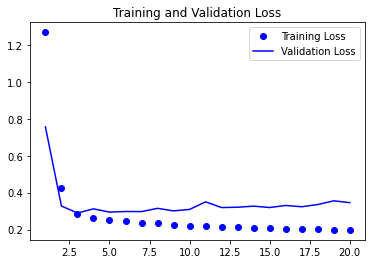

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "bo", label = "Training Loss")
plt.plot(epochs, val_loss, "b", label = "Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

일부 검증 손실은 학습을 사용하지 않은 기준점 (0.29)에 가깝지만 안정적이지 못합니다. 앞서 기준 모델을 만든 것이 도움이 됩니다. 이 문제는 기준 모델의 성능을 앞지르기가 쉽지 않습니다.

### 첫번째 순환 신경망

첫번째 완전 연결 네트워크는 잘 작동하지 않았습니다.
* 시계열 데이터를 펼쳤기 때문에 입력 데이터에서 시간 개념을 잃어버렸습니다

이런 시퀀스 데이터에 잘 들어맞는 순환 시퀀스 처리 모델로 다시 시도해보겠습니다
* **Gated Recurrent Unit (GRU)** 층은 LSTM과 같은 원리로 작동하지만 조금 더 간결하고 계산 비용이 덜 듭니다
* 하지만 LSTM만큼 표현 학습 능력이 뛰어나지는 않습니다
* 계산 비용과 학습 능력 사이의 Tradeoff는 머신 러닝 어디에나 등장합니다

##### GRU를 사용한 모델 훈련하기

In [13]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
#                               steps_per_epoch = 200,
#                               epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 9s 15ms/step - loss: 0.3209 - val_loss: 0.2732
Epoch 2/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2862 - val_loss: 0.2627
Epoch 3/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2788 - val_loss: 0.2648
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2760 - val_loss: 0.2640
Epoch 5/20
500/500 [==============================] - 7s 15ms/step - loss: 0.2729 - val_loss: 0.2602
Epoch 6/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2678 - val_loss: 0.2636
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.2631 - val_loss: 0.2631
Epoch 8/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2641 - val_loss: 0.2673
Epoch 9/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2567 - val_loss: 0.2639
Epoch 10/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2560 - val_lo

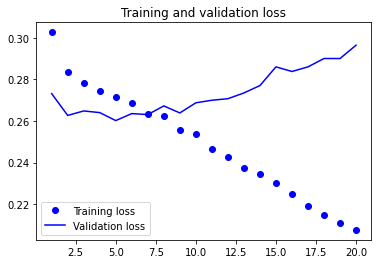

In [14]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

상식 수준의 모델을 크게 앞질렀습니다 (검증 MAE < 0.29). 이 그림은 시퀀스를 펼처서 처리하는 완전 연결 네트워크에 비해서 순환 네트워크가 이런 종류의 작업에 훨씬 뛰어나다는 것을 보여줍니다.

### 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

##### 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout = 0.2,
                     recurrent_dropout = 0.2,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = "mae")

history = model.fit_generator(train_gen,
#                               steps_per_epoch = 500,
#                               epochs = 40,
                              steps_per_epoch = 200,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
200/200 [==============================] - 69s 343ms/step - loss: 0.3385 - val_loss: 0.2934
Epoch 2/20
200/200 [==============================] - 68s 341ms/step - loss: 0.3134 - val_loss: 0.2792
Epoch 3/20
200/200 [==============================] - 68s 339ms/step - loss: 0.3078 - val_loss: 0.2797
Epoch 4/20
200/200 [==============================] - 69s 347ms/step - loss: 0.3036 - val_loss: 0.2747
Epoch 5/20
200/200 [==============================] - 67s 334ms/step - loss: 0.3008 - val_loss: 0.2747
Epoch 6/20
200/200 [==============================] - 67s 338ms/step - loss: 0.3000 - val_loss: 0.2749
Epoch 7/20
200/200 [==============================] - 68s 341ms/step - loss: 0.2995 - val_loss: 0.2715
Epoch 8/20
200/200 [==============================] - 67s 337ms/step - loss: 0.2986 - val_loss: 0.2783
Epoch 9/20
200/200 [==============================] - 68s 339ms/step - loss: 0.2973 - val_loss: 0.2748
Epoch 10/20
200/200 [==============================] - 67s 338ms/step - l

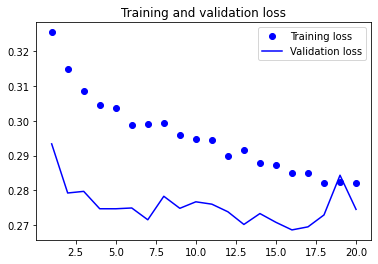

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

평가 점수는 안정적이지만 이전보다 더 나아지지는 않았습니다.

### 스태킹 순환 층

과대적합은 더 이상 없지만 **성능상 병목**이 있는 것 같으므로 네트워크의 용량을 늘려야 합니다.
* 드롭아웃 등을 사용하여 과대적합을 줄이는 기본 단계를 거치고
* 과대적합이 일어날때까지 네트워크의 용량을 늘리는게 좋습니다.
* 너무 많이 과대적합하지 않으면 충분한 용량에 도달한 것이 아닙니다.

네트워크의 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가합니다. 순환 층 스태킹은 더 강력한 순환 네트워크 만드는 고전적인 방법입니다.

케라스에서 순환 층을 차례대로 쌓으려면 모든 중간층은 마지막 타임스텝 출력만 아니고 전체 시퀀스 (3D 텐서)를 출력해야 합니다. (`return_sequences = True`)

##### 드롭아웃으로 규제하고 스태킹한 GRU 모델을 훈련하고 평가하기

In [18]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.1,
                     recurrent_dropout = 0.5,
                     return_sequences = True,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.GRU(64, activation = 'relu',
                    dropout = 0.1,
                    recurrent_dropout = 0.5))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = "mae")

history = model.fit_generator(train_gen,
#                               steps_per_epoch = 500,
#                               epochs = 40,
                              steps_per_epoch = 500,
                              epochs = 10,
                              validation_data = val_gen,
                              validation_steps = val_steps,
                              verbose = 1)

Epoch 1/10
500/500 [==============================] - 286s 568ms/step - loss: 0.3508 - val_loss: 0.2784
Epoch 2/10
500/500 [==============================] - 287s 575ms/step - loss: 0.3009 - val_loss: 0.2789
Epoch 3/10
500/500 [==============================] - 284s 568ms/step - loss: 0.2984 - val_loss: 0.2768
Epoch 4/10
500/500 [==============================] - 280s 561ms/step - loss: 0.2869 - val_loss: 0.2697
Epoch 5/10
500/500 [==============================] - 277s 555ms/step - loss: 0.2817 - val_loss: 0.2795
Epoch 6/10
500/500 [==============================] - 274s 548ms/step - loss: 0.2741 - val_loss: 0.2735
Epoch 7/10
500/500 [==============================] - 274s 548ms/step - loss: 0.2701 - val_loss: 0.2712
Epoch 8/10
500/500 [==============================] - 273s 546ms/step - loss: 0.2664 - val_loss: 0.2739
Epoch 9/10
500/500 [==============================] - 273s 546ms/step - loss: 0.2622 - val_loss: 0.2754
Epoch 10/10
500/500 [==============================] - 273s 546m

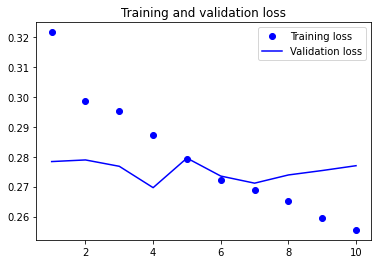

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

층을 추가하여 성능을 조금 향상시켰지만 크지는 않습니다. 두가지 결론을 얻을 수 있습니다
* 아직 충분히 과대적합을 만들지 못했기 때문에 검증 손실을 향상하기 위해 층의 크기를 늘릴 수 있습니다. 하지만 적지 않은 비용이 추가됩니다
* 층을 추가한 만큼 도움이 되지 않으므로, 여기서는 네트워크의 용량을 늘리는 것이 도움이 되지 않는다고 볼 수 있습니다.

### 양방향 RNN

마지막 기법은 **양방향 RNN (bidirectional RNN)**입니다. 양방향 RNN은 RNN의 한 변종으로 특정 작업에서 기존 RNN보다 좋은 성능을 보여줍니다. 자연어 처리에서는 *맥가이버 칼*이라고 할 정도로 자주 사용됩니다.

RNN은 순서 또는 시간에 특히 민감합니다. 즉 입력 시퀀스의 타임스텝 순서대로 처리합니다. 타임스텝을 섞거나 거꾸로 하면 RNN이 시퀀스에서 학습하는 표현을 완전히 바꾸어 버립니다.

양방향 RNN은 RNN이 순서에 민감하다는 성질을 사용합니다. 앞서 보았던 GRU나 LSTM같은 RNN 2개를 사용합니다. 각 RNN은 입력 시퀀스를 한 방향 (시간 순서나 반대 순서)으로 처리한 후 각 표현을 합칩니다. 시퀀스를 양쪽 방향으로 처리하기때문에 양방향 RNN은 단방향 RNN이 놓치기 쉬운 패턴을 감지할 수 있습니다.

놀랍게도 RNN층이 시간의 순서대로 시퀀스를 처리하는 것은 **근거 없는** 결정입니다. 시간의 반대 방향으로 입력 시퀀스를 처리하면 만족할만한 RNN 성능을 낼 수 있을까요? 실제로 이렇게 해보고 결과를 확인해보죠. 해야 할 일은 입력 시퀀스를 시간 차원을 따라 거꾸로 생성하는 데이터 제너레이터 만드는 것 뿐입니다(제너레이터 함수의 마지막 줄을 `yield samples[:, ::-1, :], targets`로 바꿉니다). 이 절의 첫 번째 예제와 동일하게 하나의 GRU 층을 가진 네트워크를 훈련합니다:



In [20]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [21]:
model = Sequential()
model.add(layers.GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch = 500,
                              epochs = 40,
                              validation_data = val_gen_reverse,
                              validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 7s 14ms/step - loss: 0.4859 - val_loss: 0.4789
Epoch 2/40
500/500 [==============================] - 7s 13ms/step - loss: 0.4565 - val_loss: 0.4430
Epoch 3/40
500/500 [==============================] - 7s 14ms/step - loss: 0.3874 - val_loss: 0.3821
Epoch 4/40
500/500 [==============================] - 7s 14ms/step - loss: 0.3387 - val_loss: 0.3539
Epoch 5/40
500/500 [==============================] - 7s 14ms/step - loss: 0.3089 - val_loss: 0.3423
Epoch 6/40
500/500 [==============================] - 7s 13ms/step - loss: 0.2929 - val_loss: 0.3460
Epoch 7/40
500/500 [==============================] - 8s 15ms/step - loss: 0.2813 - val_loss: 0.3264
Epoch 8/40
500/500 [==============================] - 8s 17ms/step - loss: 0.2719 - val_loss: 0.3369
Epoch 9/40
500/500 [==============================] - 7s 14ms/step - loss: 0.2640 - val_loss: 0.3331
Epoch 10/40
500/500 [==============================] - 7s 14ms/step - loss: 0.2574 - val_lo

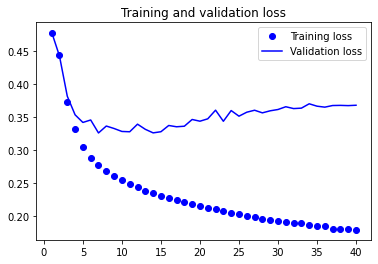

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

순서를 뒤집은 GRU는 상식 수준의 기준점보다도 성능이 낮습니다. 이 경우에는 시간 순서대로 처리하는 것이 중요한 역할을 합니다. 기본적인 GRU 층은 먼 과거보다 최근 내용을 잘 기억합니다.

하지만 자연어 처리를 포함하여 다른 많은 문제에서는 그렇지 않습니다. 문장을 이해하는데 있어서 단어의 중요성은 단어가 문장 어디에 놓여 있는지에 따라 결정되지 않습니다. 

##### 거꾸로 된 시퀀스를 사용한 LSTM 훈련하기 (IMDB 데이터)

In [23]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# 특성으로 사용할 단어의 수
max_features = 10000
# 사용할 텍스트의 길이(가장 빈번한 max_features 개의 단어만 사용합니다)
maxlen = 500

# 데이터 로드
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# 시퀀스를 뒤집습니다
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 시퀀스에 패딩을 추가합니다
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 128,
                    validation_split = 0.2)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or sha

Epoch 1/10
157/157 [==============================] - 5s 26ms/step - loss: 0.5938 - accuracy: 0.6819 - val_loss: 0.4163 - val_accuracy: 0.8312
Epoch 2/10
157/157 [==============================] - 4s 24ms/step - loss: 0.3386 - accuracy: 0.8680 - val_loss: 0.3437 - val_accuracy: 0.8738
Epoch 3/10
157/157 [==============================] - 4s 25ms/step - loss: 0.2622 - accuracy: 0.9052 - val_loss: 0.3972 - val_accuracy: 0.8428
Epoch 4/10
157/157 [==============================] - 4s 24ms/step - loss: 0.2223 - accuracy: 0.9210 - val_loss: 0.3927 - val_accuracy: 0.8644
Epoch 5/10
157/157 [==============================] - 4s 25ms/step - loss: 0.1809 - accuracy: 0.9365 - val_loss: 0.3227 - val_accuracy: 0.8788
Epoch 6/10
157/157 [==============================] - 4s 24ms/step - loss: 0.1475 - accuracy: 0.9495 - val_loss: 0.3797 - val_accuracy: 0.8548
Epoch 7/10
157/157 [==============================] - 4s 24ms/step - loss: 0.1321 - accuracy: 0.9547 - val_loss: 0.4431 - val_accuracy: 0.8500

시간 순서로 훈련한 LSTM과 거의 동일한 성능을 얻을 수 있습니다. 놀랍게도 이런 텍스트 데이터에서는 순서를 뒤집어 처리하는 것이 시간 순서대로 처리하는 것과 거의 동일하게 작동합니다.

거꾸로 된 시퀀스에서 훈련한 RNN은 원래 시퀀스에서 훈련한 것과는 **다른 표현**을 학습합니다. 머신 러닝에서는 다른 표현이 유용하다면 항상 사용할 가치가 있습니다. 새로운 시각을 제공하고 다른 방식에서는 놓칠 수 있는 데이터의 특징을 잡아냅니다. 이 것이 Ensemble의 개념입니다

양방향 RNN은 이 아이디어를 사용하여 시간 순서대로 처리하는 RNN의 성능을 향상시킵니다. 입력 시쿼스를 양쪽 방향에서 바라보기 때문에 드러나지 않은 다양한 표현을 얻어 시간 순서대로 처리할때 놓칠 수 있는 패턴을 잡아냅니다.

<br></br>
![](../images/6-3-bidirection.png)
<br></br>

케라스에서는 **Bidirectional 층**을 사용하여 양방향 RNN을 만듭니다.

##### 양방향 LSTM을 훈련하고 평가하기

In [24]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ["acc"])

history = model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.2)

Epoch 1/10
157/157 [==============================] - 6s 32ms/step - loss: 0.6486 - acc: 0.6120 - val_loss: 0.5215 - val_acc: 0.7546
Epoch 2/10
157/157 [==============================] - 5s 29ms/step - loss: 0.3806 - acc: 0.8516 - val_loss: 0.4282 - val_acc: 0.8114
Epoch 3/10
157/157 [==============================] - 4s 29ms/step - loss: 0.2759 - acc: 0.8959 - val_loss: 0.3224 - val_acc: 0.8794
Epoch 4/10
157/157 [==============================] - 4s 28ms/step - loss: 0.2360 - acc: 0.9167 - val_loss: 0.4003 - val_acc: 0.8752
Epoch 5/10
157/157 [==============================] - 5s 29ms/step - loss: 0.2022 - acc: 0.9305 - val_loss: 0.3119 - val_acc: 0.8734
Epoch 6/10
157/157 [==============================] - 5s 30ms/step - loss: 0.1761 - acc: 0.9424 - val_loss: 0.3102 - val_acc: 0.8790
Epoch 7/10
157/157 [==============================] - 4s 29ms/step - loss: 0.1608 - acc: 0.9469 - val_loss: 0.3868 - val_acc: 0.8408
Epoch 8/10
157/157 [==============================] - 4s 28ms/step - 

검증 정확도는 88%로 일반 LSTM보다 성능이 조금 더 높습니다. 이 모델은 조금 더 빠르게 과대적합이 되는 것 같습니다. **양방향** 순환층이 일반 순환층에 비해 파라미터가 2배 많기 때문에 놀라운 일이 아닙니다. 규제를 조금 추가한다면 양방향 순환 층을 사용하는 것이 이 작업에 더 적합해 봅니다.

같은 방식을 온도 예측 문제에 적용해보겠습니다.

##### 양방향 GRU 훈련하기

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer = RMSprop(), loss = "mae")

history = model.fit_generator(train_gen,
#                             steps_per_epoch = 500,
#                               epochs = 40,
                              steps_per_epoch = 200,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
200/200 [==============================] - 8s 34ms/step - loss: 0.3170 - val_loss: 0.2857
Epoch 2/20
200/200 [==============================] - 6s 33ms/step - loss: 0.2854 - val_loss: 0.2726
Epoch 3/20
200/200 [==============================] - 7s 33ms/step - loss: 0.2807 - val_loss: 0.2756
Epoch 4/20
200/200 [==============================] - 7s 35ms/step - loss: 0.2753 - val_loss: 0.2731
Epoch 5/20
200/200 [==============================] - 7s 34ms/step - loss: 0.2740 - val_loss: 0.2676
Epoch 6/20
200/200 [==============================] - 7s 34ms/step - loss: 0.2690 - val_loss: 0.2685
Epoch 7/20
200/200 [==============================] - 7s 33ms/step - loss: 0.2705 - val_loss: 0.2696
Epoch 8/20
200/200 [==============================] - 7s 33ms/step - loss: 0.2683 - val_loss: 0.2651
Epoch 9/20
200/200 [==============================] - 7s 33ms/step - loss: 0.2642 - val_loss: 0.2653
Epoch 10/20
200/200 [==============================] - 7s 33ms/step - loss: 0.2639 - val_lo

이 네트워크는 일반 GRU층과 비슷한 성능을 냅니다. 모든 예측 성능은 시간 순서대로 처리하는 네트워크의 절반에서 옵니다. 시간 반대 순서로 처리하는 절반은 이런 작업에 성능이 매우 좋지 않기 떄문입니다.